In [1]:
import rosbag
import cv2
import numpy as np
from tqdm import tqdm
import bisect
from loguru import logger
import matplotlib.pyplot as plt

In [2]:
bag = rosbag.Bag('/mnt/UNENCRYPTED/ruichend/seq/seq3/seq_3.bag')
gps_fixed_msgs = []
for topic, msg, t in bag.read_messages(topics=['/mavros/global_position/raw/fix']):
    gps_fixed_msgs.append(msg)

In [11]:
april = np.load('./logs/seq3_april1.npy')

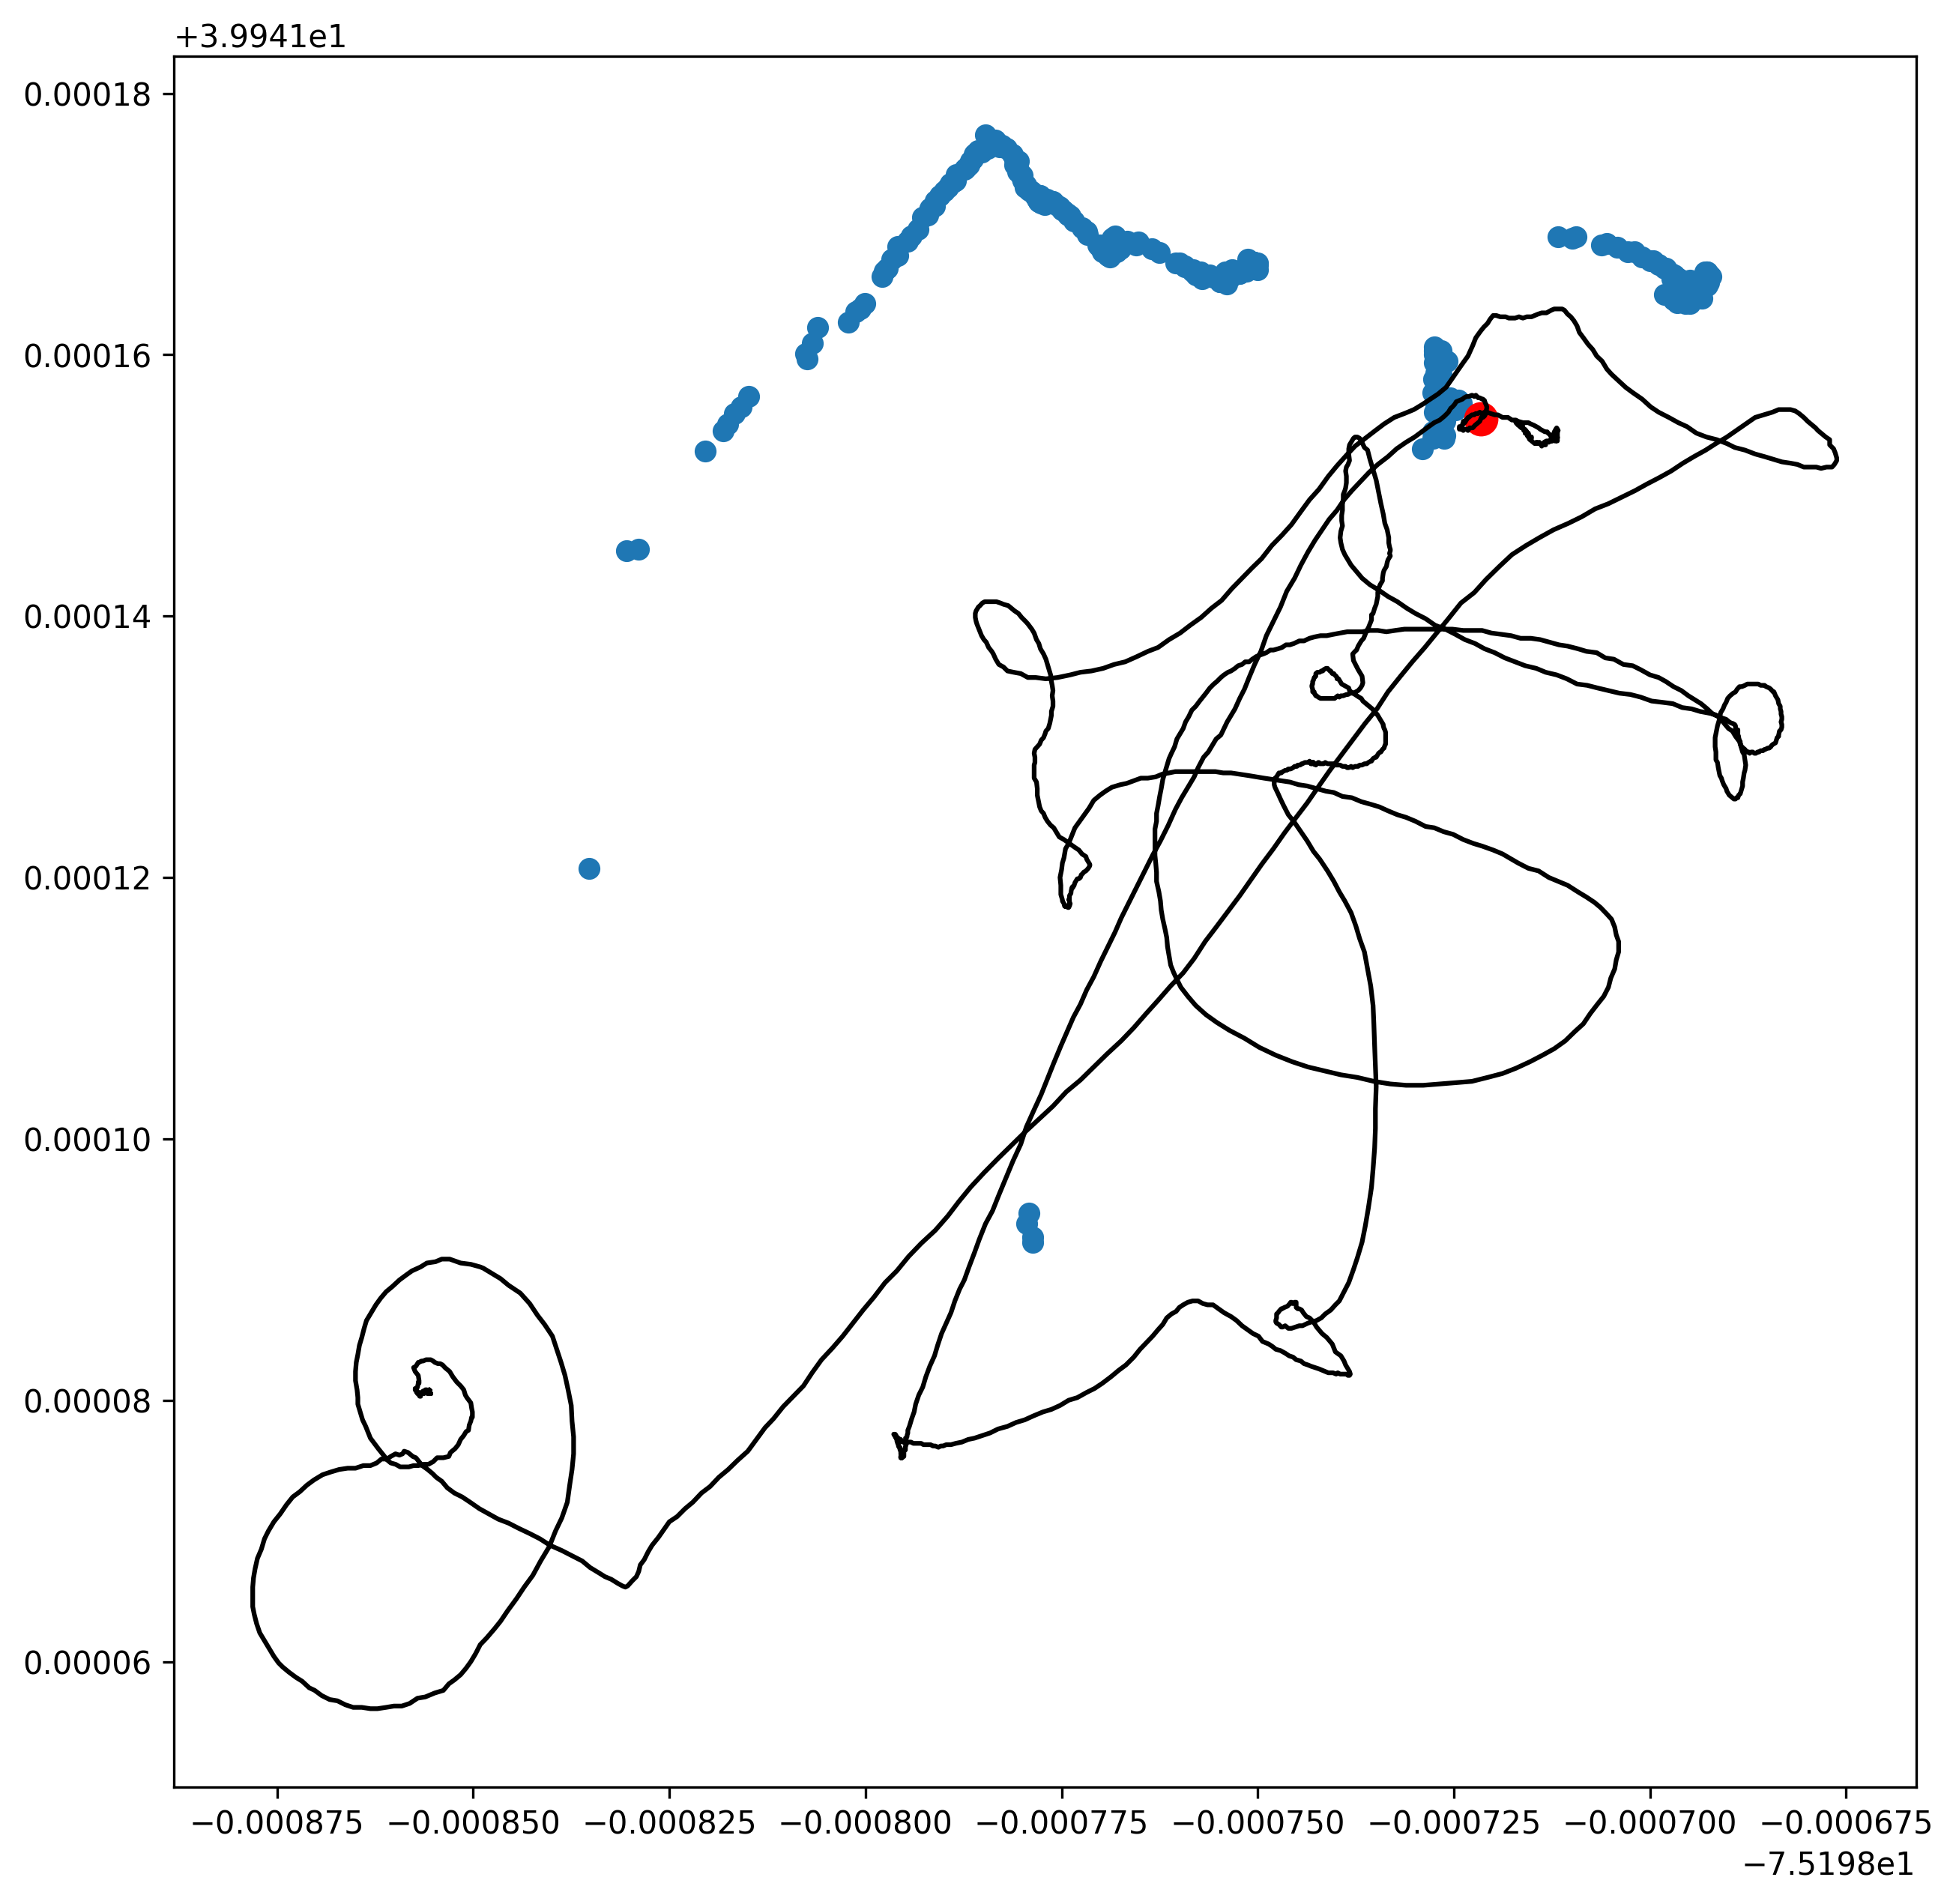

In [12]:
xyz = []

for msg in gps_fixed_msgs:
    xyz.append(
        [msg.longitude, msg.latitude, msg.altitude]
    )

xyz = np.array(xyz)
z0 = xyz[0, -1]
xyz = xyz - np.array([0, 0, z0])

plt.figure(figsize=(10, 10), dpi =300)
plt.plot(xyz[:, 0], xyz[:, 1], c='k')
plt.scatter(april[:, 0], april[:, 1])
# plt.xlim(xyz[:, 0].min(), xyz[:, 0].max())
# plt.ylim(xyz[:, 1].min(), xyz[:, 1].max())
# plt.xlim(-75.1995, -75.1980)
# plt.ylim(39.9408, 39.94125)
plt.scatter([-75.1987216], [39.9411551], c='r', s=100, label='GPS')

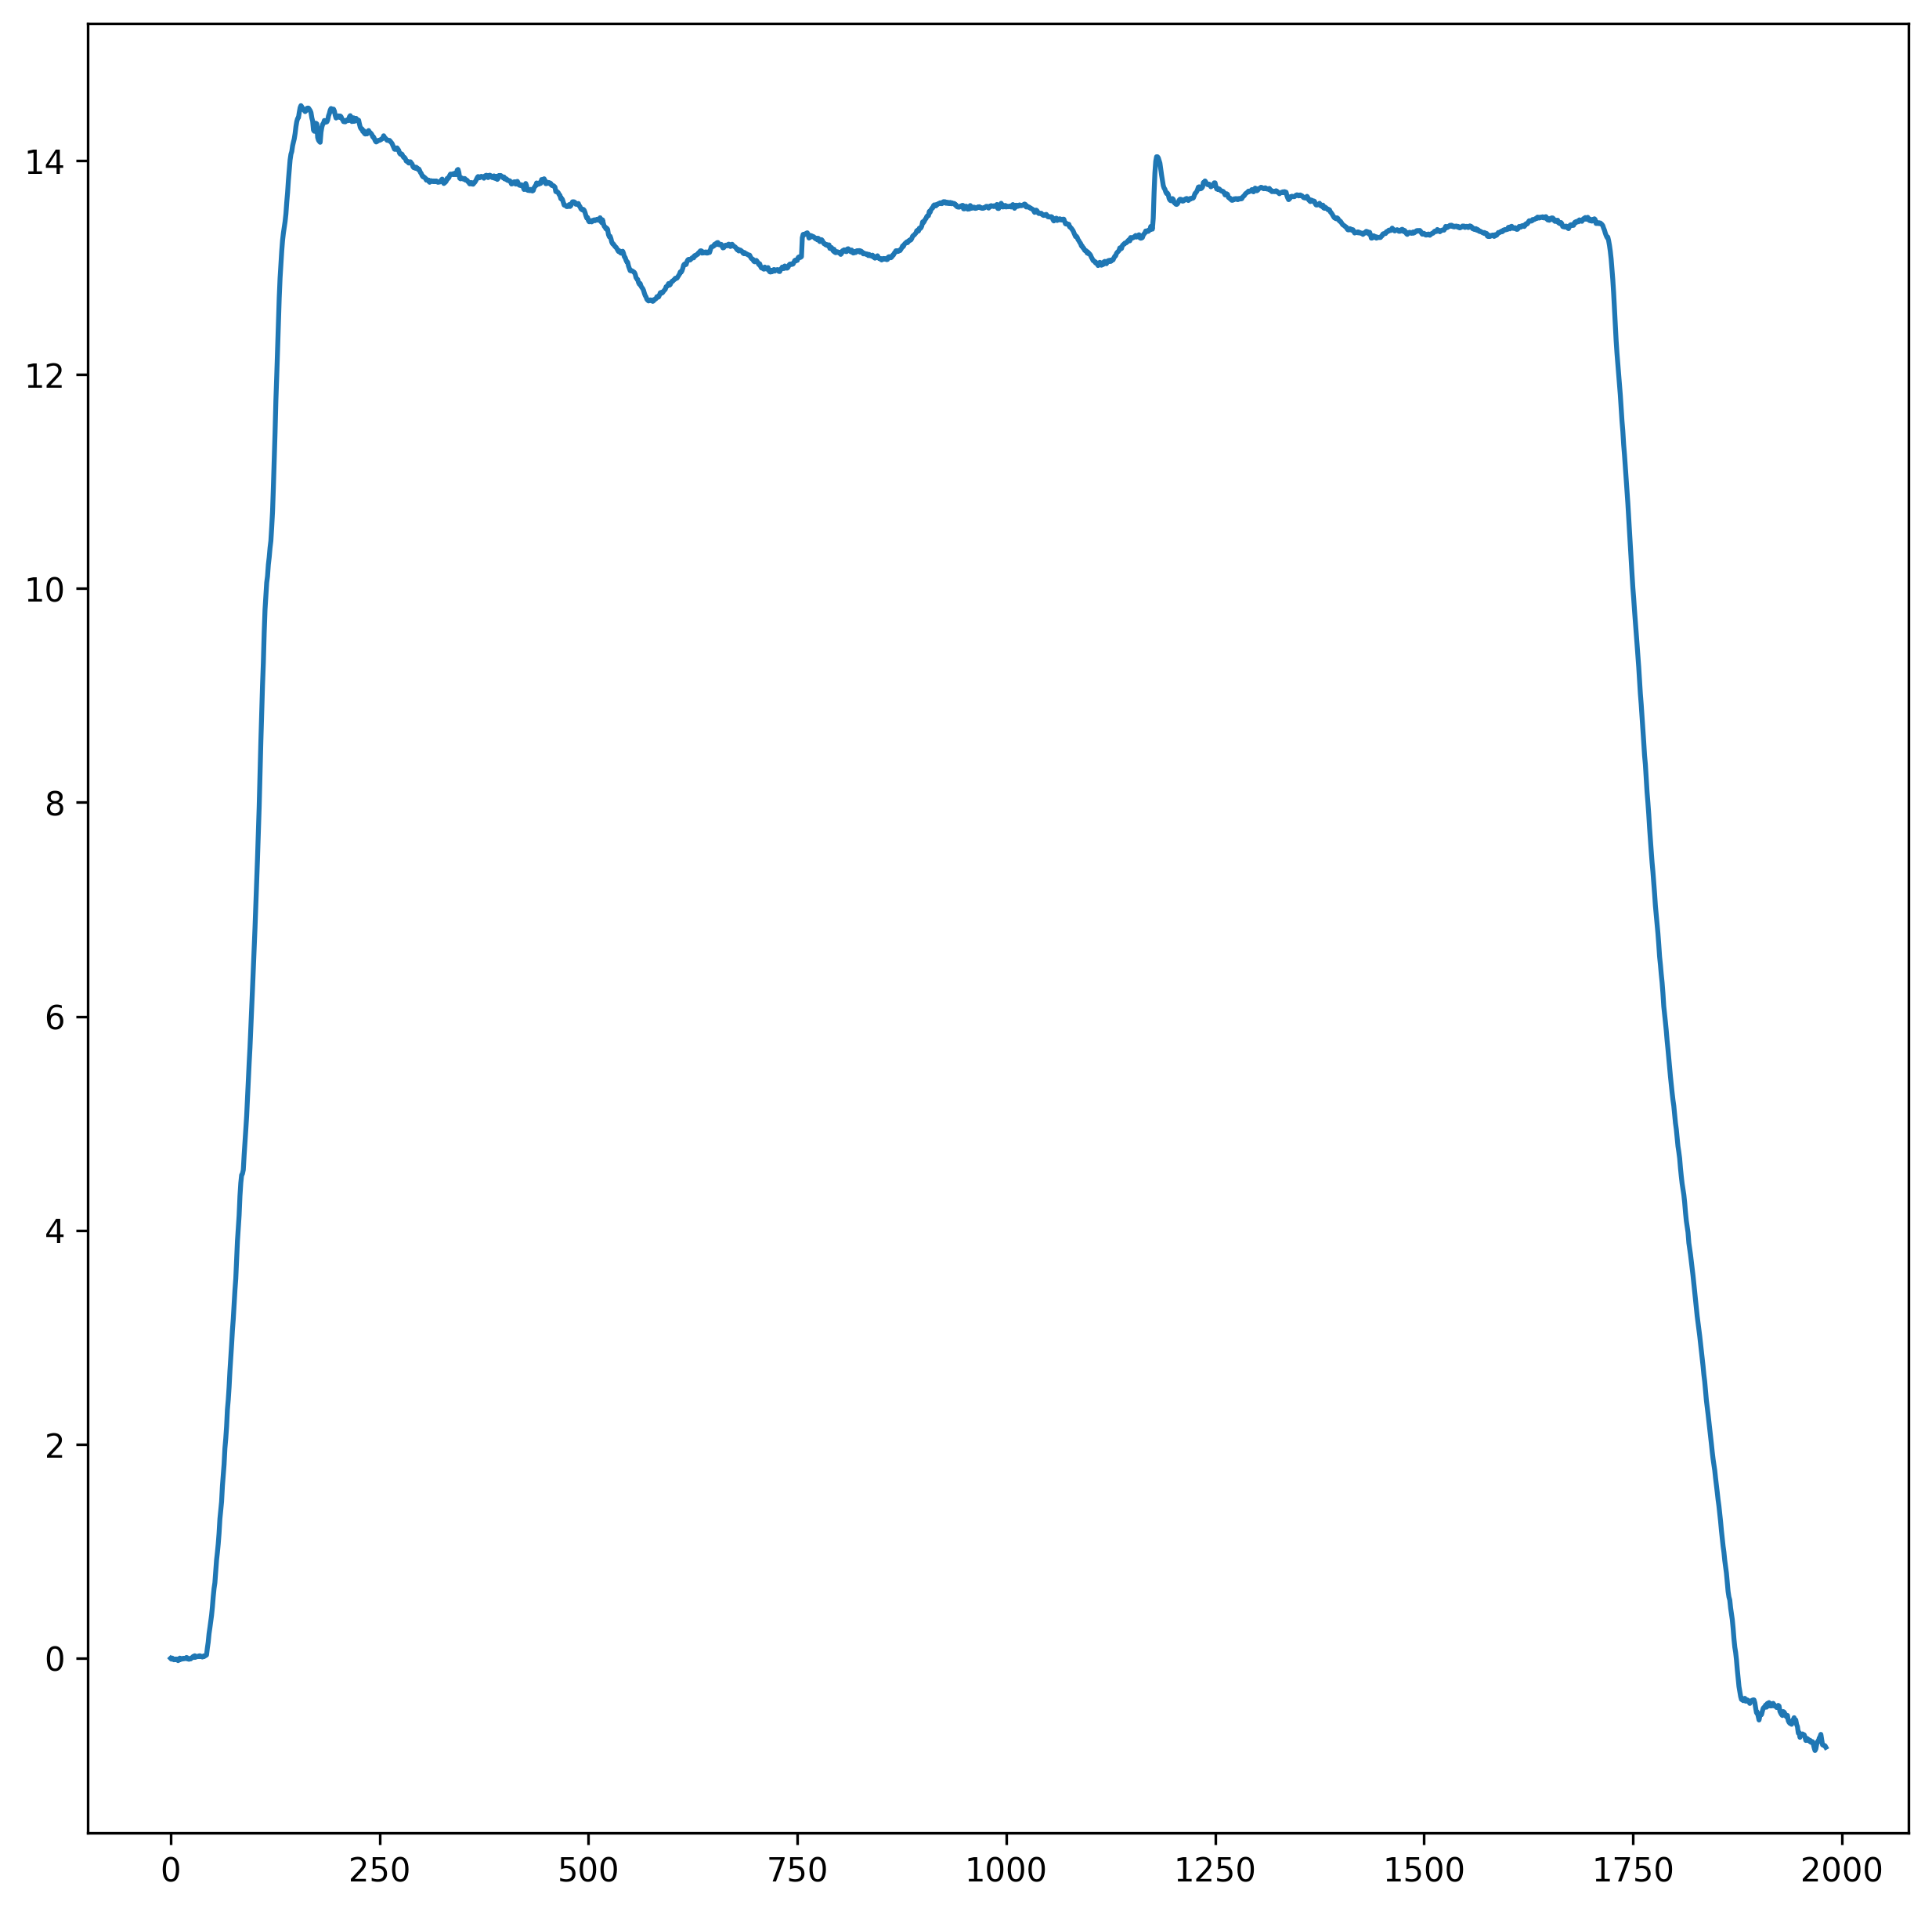

In [13]:
plt.figure(plt.figure(figsize=(10, 10), dpi =300))
plt.plot(xyz[:, 2])